# Are there Persistening Effects of the Berlin Divison on short-term AirBnB Market in Germany?

In XXX, in Berlin, Germany the XXX divided the city into East-Germany and West Germany.  The wall stood from XXX to XXX.  The characterists of East-Germany are XXX. The characteristis of West-Germany are XXX. Today, the split 


Aayush Dhakal, Nicols Pazos, Sharanya Bhattacharjee, and Melissa Carson
ACE 592,  2025

- [Table of Contents](#toc1_)    
    - [**Data Background**](#toc1_1)
    - [**Data Preparation**](#toc1_1)
    - [**Categorical Differences**](#toc1_1_2)    
    - [**Spatial Analysis**](#toc1_1_2)       
    - [**Sentiment Analysis**](#toc1_1_3)    
    - [**Numeric Analysis**](#toc1_1_4)    
    - [**Granular Analysis**](#toc1_1_6)    
    - [**Other Analyses**](#toc1_1_7)  

[**Data Background**](#toc1_1)

The Data is from Inside AirBnB, https://insideairbnb.com/berlin/

Inside AirBnB Description: "Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. We work towards a vision where communities are empowered with data and information to understand, decide and control the role of renting residential homes to tourists...Inside Airbnb is mission-driven and supports residents and activists who are organising to protect their communities from the negative effects of short-term rentals. Inside Airbnb deeply believes in the power of community, in sharing resources and celebrating successes."

Documentation of Data Assumptions, https://insideairbnb.com/data-assumptions/

Summary of relevant Data Assumptions and Limitations:
 - "Location information for listings are anonymized by Airbnb.
In practice, this means the location for a listing on the map, or in the data will be from 0-450 feet (150 metres) of the actual address.
Listings in the same building are anonymized by Airbnb individually, and therefore may appear "scattered" in the area surrounding the actual address."
 - "Neighbourhood names for each listing are compiled by comparing the listing's geographic coordinates with a city's definition of neighbourhoods. Airbnb neighbourhood names are not used because of their inaccuracies."
- "The Airbnb calendar for a listing does not differentiate between a booked night vs an unavailable night, therefore these bookings have been counted as 'unavailable'. This serves to understate the Availability metric because popular listings will be "booked" rather than being 'blacked out' by a host."
- "One of the biggest issues with Airbnb is whether hosts are renting out residential properties permanently as hotels, as opposed to sharing the primary residence in which they live 'occasionally'. An occupancy model can be used to estimate how often an Airbnb listing is being rented out, and also approximate a listing's income."
- "A Review Rate of 50% is used to convert reviews to estimated bookings."
- "An average length of stay, where avaialble, is configured for each city, and this, multiplied by the estimated bookings for each listing over a period gives the occupancy rate"



[**Data Preparation**](#toc1_1)


In [2]:
# I think this is everything we used on HW  + HW 1 + HW 2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import pyproj
import rasterio
import rasterstats
import json
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.colors as pltc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
from nltk.corpus import stopwords
import string
import emoji
from datetime import timedelta


In [3]:
### MUST BE CHANGED? AN EASIER WAY?
data_dir= "C:/Users/mc127/Box/Data Science Project"

###
### SPATIAL DATA
###
### All Germany
germ = geopandas.read_file(data_dir+"/boundary/Germany_Shapefile/de_1km.shp")
print(germ.head())

### East-West Germany
ew_germ = geopandas.read_file(data_dir+"/boundary/gmu-germany-coldwar-boundary-geojson.json")
print(ew_germ.head())

        CELLCODE  EOFORIGIN  NOFORIGIN  \
0  1kmE3890N3643    3890000    3643000   
1  1kmE3890N3644    3890000    3644000   
2  1kmE3890N3645    3890000    3645000   
3  1kmE3890N3646    3890000    3646000   
4  1kmE3890N3647    3890000    3647000   

                                            geometry  
0  POLYGON ((3890000 3643000, 3890000 3644000, 38...  
1  POLYGON ((3890000 3644000, 3890000 3645000, 38...  
2  POLYGON ((3890000 3645000, 3890000 3646000, 38...  
3  POLYGON ((3890000 3646000, 3890000 3647000, 38...  
4  POLYGON ((3890000 3647000, 3890000 3648000, 38...  
                           id  objectid_1  objectid   name_0 country  \
0  germany_coldwar_boundary.1           1         1  Germany    None   
1  germany_coldwar_boundary.2           2         2  Germany    None   
2  germany_coldwar_boundary.3           3         0     None    None   
3  germany_coldwar_boundary.4           4         0     None    None   
4  germany_coldwar_boundary.5           5         0     N

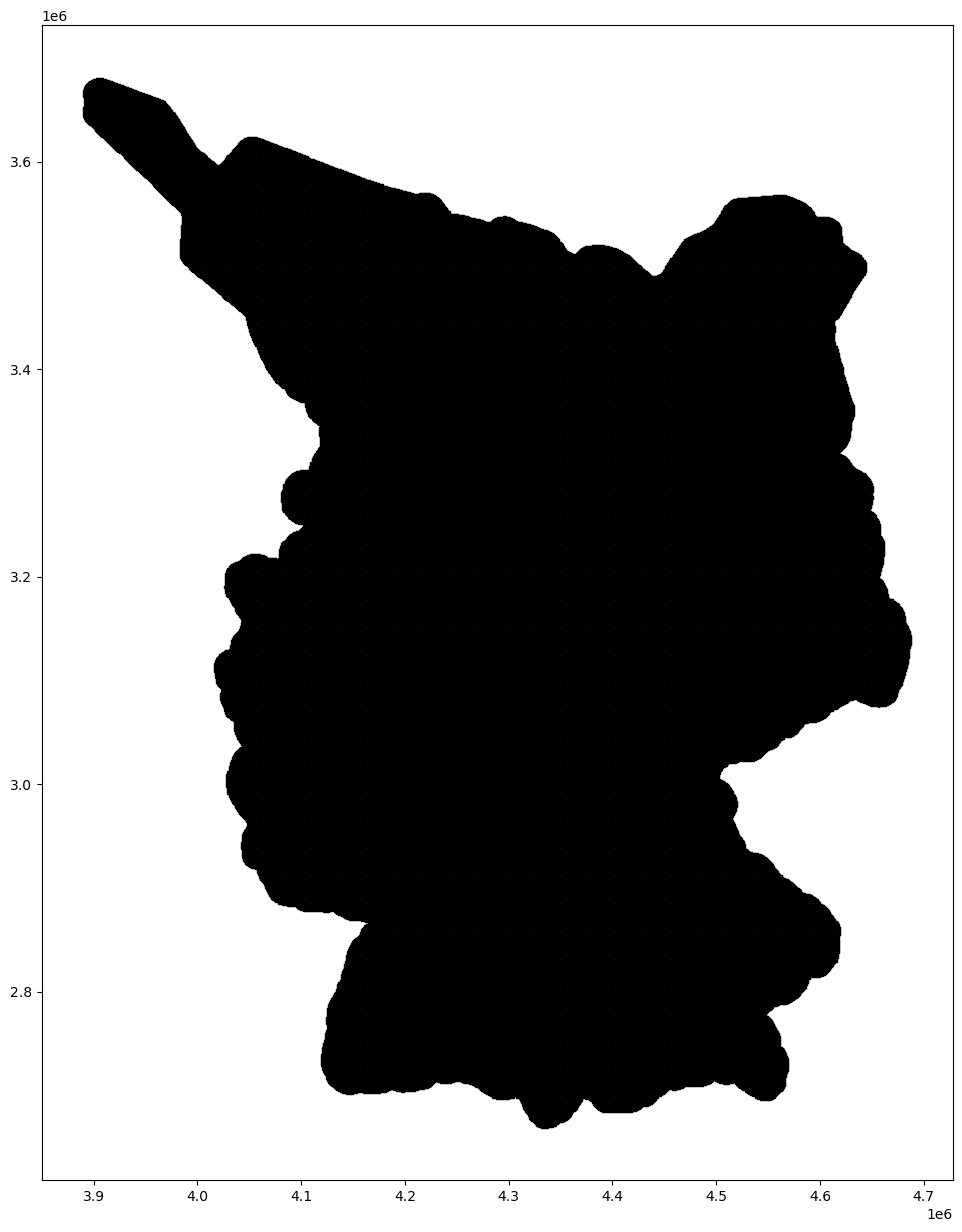

In [3]:
#fig, ax = plt.subplots(figsize=(15, 15))
#germ.plot(ax=ax, facecolor='none', edgecolor='black')
#plt.show()

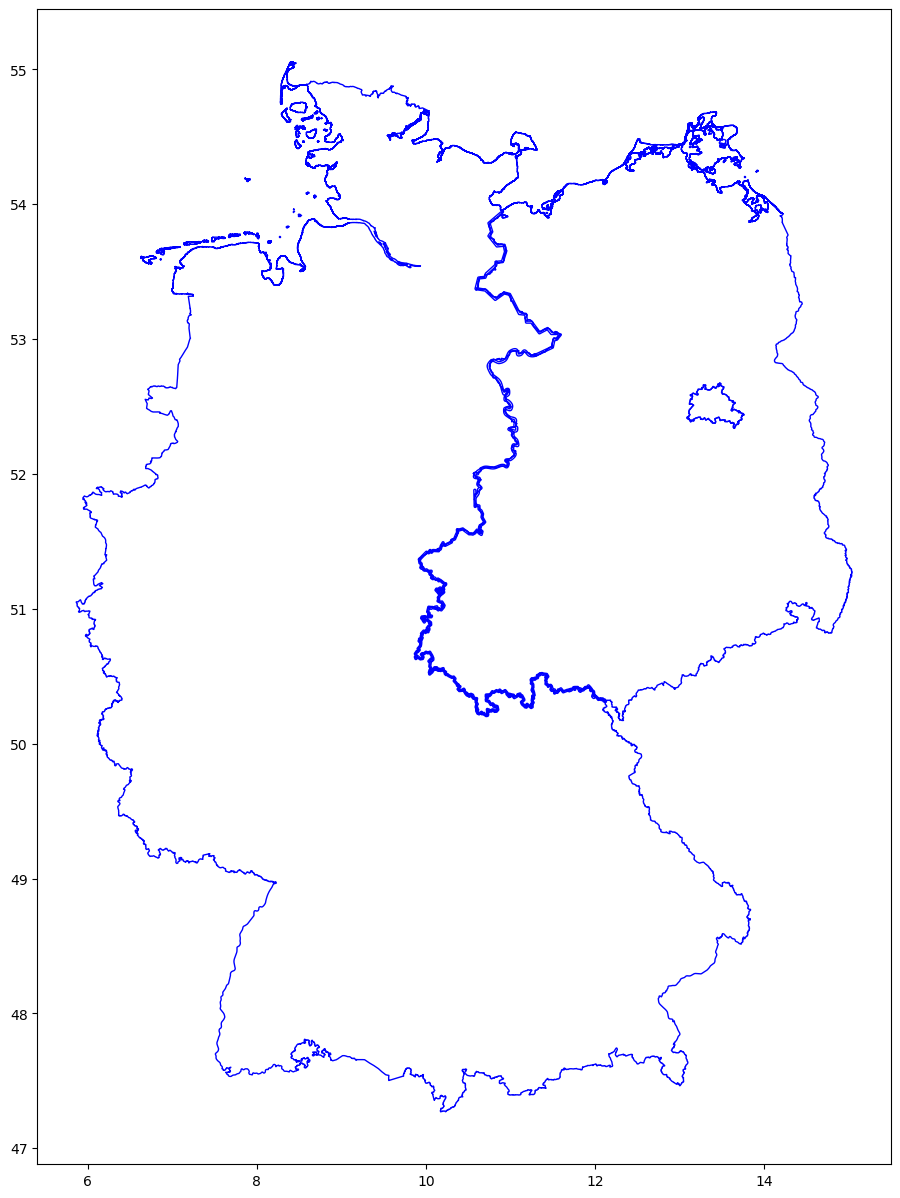

In [4]:
#fig, ax = plt.subplots(figsize=(15, 15))
#ew_germ.plot(ax=ax, facecolor='none', edgecolor='blue')
#plt.show()

In [7]:
###
### AIRBNB DATA
###

# For each respective csv in each respective month, open and append together. 
# The months are 03, 06, 09, 12
# The names of the csv are 1) listings 2) neighbourhoods 3) reviews 4) calendar
# The folder structre is 2021-XX where XX is the month, inside each folder is the csv name


import pandas as pd
import os

months = ['03', '06', '09', '12']
csv_names = ['listings.csv', 'neighbourhoods.csv', 'reviews.csv']

combined_data = {name: [] for name in csv_names}

for month in months:
    folder = f"2024-{month}"
    for csv_file in csv_names:
        file_path = f"{data_dir}/{folder}/{csv_file}"
        try:
            df = pd.read_csv(file_path)
            df['source_month'] = month
            combined_data[csv_file].append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Combine each list of DataFrames into a single one
listings_df = pd.concat(combined_data['listings.csv'], ignore_index=True)
neighbourhoods_df = pd.concat(combined_data['neighbourhoods.csv'], ignore_index=True)
reviews_df = pd.concat(combined_data['reviews.csv'], ignore_index=True)


In [9]:
print(listings_df.head())
print(neighbourhoods_df.head())
print(reviews_df.head())

      id                                           name  host_id  \
0   3176                Fabulous Flat in great Location     3718   
1   9991            Geourgeous flat - outstanding views    33852   
2  14325            Studio Apartment in Prenzlauer Berg    55531   
3  16644             In the Heart of Berlin - Kreuzberg    64696   
4  17904  Beautiful Kreuzberg studio - 3 months minimum    68997   

        host_name       neighbourhood_group             neighbourhood  \
0          Britta                    Pankow   Prenzlauer Berg Südwest   
1         Philipp                    Pankow   Prenzlauer Berg Südwest   
2  Chris + Oliver                    Pankow  Prenzlauer Berg Nordwest   
3            Rene  Friedrichshain-Kreuzberg     nördliche Luisenstadt   
4        Matthias                  Neukölln              Reuterstraße   

   latitude  longitude        room_type  price  minimum_nights  \
0  52.53471   13.41810  Entire home/apt   83.0              63   
1  52.53269   13.418

[**Categorical Differences**](#toc1_1_2)    


[**Spatial Analysis**](#toc1_1_2)    

[**Sentiment Analysis**](#toc1_1_3)    


[**Numeric Analysis**](#toc1_1_4) 

[**Granular Analysis**](#toc1_1_6)    


[**Other Analysis**](#toc1_1_7)
